# PARTIE 2 :IMPLEMENTATION

##***Exploration***

In [9]:
import pandas as pd
# Charger le dataset
print(" Chargement du dataset...")
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentiment140_all_attributes.csv")
df.head()

 Chargement du dataset...


,text,sentiment,user_account_age_days,user_gender,user_location,user_num_posts,user_num_retweets,user_num_followers,tweet_hour,tweet_num_likes,user_profile_type
0,"Thanks MASN, no Yankee game due to local black...",0,191,male,"Los Angeles, CA",595,180,186,15:58:58,0,regular
1,@gylliwilli get em Gilly!!!! see yall in a min...,0,444,female,"Los Angeles, CA",597,198,13,22:16:12,1,casual
2,Ah meee's not well Meeee's needs some love ...,0,415,male,Unknown,3304,978,90,09:01:26,0,regular
3,is home.,4,406,female,"New York, NY",217,86,50,03:51:31,0,casual
4,Just been watching some E3 videos on Gamespot....,0,246,male,"Toronto, Canada",390,127,88,22:56:04,2,regular


In [10]:
def explore_data(df):
  print("___  Taille et information generale ___ \n")
  df.shape
  df.info()
  print("___  Statistiques descriptives ___ \n")
  print("\t _Valeurs numeriques ")
  print(df.describe())
  print("\t _Valeurs Categorielles ")
  print(df.describe(include=['object']))
  print("___  Valeurs manquantes ___ \n")
  missing = df.isnull().sum()
  missing_percent = (missing / len(df)) * 100
  missing_df = pd.DataFrame({
      'Colonne': missing.index,
      'Manquantes': missing.values,
      'Pourcentage': missing_percent.values
  })
  print(missing_df[missing_df['Manquantes'] > 0].sort_values('Manquantes', ascending=False))
  display(missing_df.head())


explore_data(df)

___  Taille et information generale ___ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   text                   45000 non-null  object
 1   sentiment              45000 non-null  int64 
 2   user_account_age_days  45000 non-null  int64 
 3   user_gender            45000 non-null  object
 4   user_location          45000 non-null  object
 5   user_num_posts         45000 non-null  int64 
 6   user_num_retweets      45000 non-null  int64 
 7   user_num_followers     45000 non-null  int64 
 8   tweet_hour             45000 non-null  object
 9   tweet_num_likes        45000 non-null  int64 
 10  user_profile_type      45000 non-null  object
dtypes: int64(6), object(5)
memory usage: 3.8+ MB
___  Statistiques descriptives ___ 

	 _Valeurs numeriques 
          sentiment  user_account_age_days  user_num_posts  user_num_retweet

,Colonne,Manquantes,Pourcentage
0,text,0,0.0
1,sentiment,0,0.0
2,user_account_age_days,0,0.0
3,user_gender,0,0.0
4,user_location,0,0.0


##***Pretraitement et split Donnees***

### *Pretraitement*

In [11]:
import nltk
import unicodedata
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Télécharger les ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
def preprocess_text(text, model_type='glove', lang='english'):
    """
    Prétraitement de texte pour tweets selon le modèle cible
    """
    if not isinstance(text, str):
        return ""

    # 1. Nettoyage de base (commun aux deux modèles)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'([!?.])\1+', r'\1', text)

    # 2. Traitement spécifique selon le modèle
    if model_type.lower() == 'glove':
        # Pour GloVe (embeddings pré-entraînés)
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        text = text.lower()
        text = re.sub(r'[^\w\s\']', ' ', text)

        tokens = word_tokenize(text)
        stop_words = set(stopwords.words(lang))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
        text = ' '.join(tokens)

    elif model_type.lower() == 'distilbert':
        # Pour DistilBERT (moins de prétraitement nécessaire)
        text = re.sub(r'[^\w\s@#]', ' ', text)
        text = ' '.join(text.split())

    # 3. Nettoyage final commun
    text = re.sub(r'\s+', ' ', text).strip()

    if model_type.lower() == 'distilbert' and len(text.split()) > 512:
        text = ' '.join(text.split()[:510]) + ' [TRUNCATED]'

    return text


def df_preprocess_text(df):
    """
    Prépare le dataset avec prétraitement des textes pour GloVe et BERT
    """
    df_preprocessed = df.copy()

    # 1. Prétraiter les textes pour GloVe
    print("Prétraitement des textes pour GloVe...")
    df_preprocessed['text_glove'] = df_preprocessed['text'].apply(
        lambda x: preprocess_text(x, model_type='glove')
    )

    # 2. Prétraiter les textes pour BERT
    print("Prétraitement des textes pour BERT...")
    df_preprocessed['text_bert'] = df_preprocessed['text'].apply(
        lambda x: preprocess_text(x, model_type='distilbert')
    )

    # 3. Supprimer les textes vides
    initial_len = len(df_preprocessed)
    df_preprocessed = df_preprocessed[
        (df_preprocessed['text_glove'].str.strip() != '') &
        (df_preprocessed['text_bert'].str.strip() != '')
    ]
    print(f"Supprimé {initial_len - len(df_preprocessed)} textes vides après prétraitement")

    return df_preprocessed

df_preprocess_tex = df_preprocess_text(df)
print("Analyse initiale des labels :")
print(f"Valeurs uniques : {df_preprocess_tex['sentiment'].unique()}")
print(f"Distribution : {df_preprocess_tex['sentiment'].value_counts()}")

# Conversion labels sentiment => 4 → 1 (si nécessaire)
if set(df_preprocess_tex['sentiment'].unique()) == {0, 4}:
    print("\nConversion des labels 4 → 1")
    df_preprocess_tex['sentiment'] = df_preprocess_tex['sentiment'].replace({4: 1})

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Prétraitement des textes pour GloVe...
Prétraitement des textes pour BERT...
Supprimé 198 textes vides après prétraitement
Analyse initiale des labels :
Valeurs uniques : [0 4]
Distribution : sentiment
0    22460
4    22342
Name: count, dtype: int64

Conversion des labels 4 → 1


In [12]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
def preprocess_user_attributes(df):
    """Prétraitement des attributs utilisateur"""

    # 1. Encodage des variables catégorielles
    le = LabelEncoder()
    df['user_gender_encoded'] = le.fit_transform(df['user_gender'])
    df['user_location_encoded'] = le.fit_transform(df['user_location'])
    df['tweet_hour'] = pd.to_datetime(df['tweet_hour'], format='%H:%M:%S').dt.hour
    # 2. Normalisation des variables numériques
    numerical_features = [
        'user_account_age_days',
        'user_num_posts',
        'user_num_followers',
        'user_num_retweets',
        'tweet_hour',
        'tweet_num_likes'
    ]

    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    return df, scaler, le
# Appliquer le prétraitement
df_preprocessed, scaler, label_encoder = preprocess_user_attributes(df_preprocess_tex)
print(f"\nDataset final: {df_preprocessed.shape}")
print(f"\n Text: {df_preprocessed.shape}")
display(df_preprocessed[['text','text_glove', 'text_bert']].head())
user_attributes = [
        'user_gender_encoded',
        'user_location_encoded',
        'user_account_age_days',
        'user_num_posts',
        'user_num_followers',
        'user_num_retweets',
        'tweet_num_likes',
        'tweet_hour'
    ]
print(f"\n user_attributes : {df_preprocessed.shape}")
display(df_preprocessed[user_attributes].head())


Dataset final: (44802, 15)

 Text: (44802, 15)


,text,text_glove,text_bert
0,"Thanks MASN, no Yankee game due to local black...",thanks masn yankee game due local blackout,Thanks MASN no Yankee game due to local blackout
1,@gylliwilli get em Gilly!!!! see yall in a min...,get em gilly see yall minute closed freakin la...,get em Gilly see yall in a minute they closed ...
2,Ah meee's not well Meeee's needs some love ...,ah meee 's well meeee 's needs love care fuck ...,Ah meee s not well Meeee s needs some love and...
3,is home.,home,is home
4,Just been watching some E3 videos on Gamespot....,watching e3 videos gamespot really want xbox 360,Just been watching some E3 videos on Gamespot ...



 user_attributes : (44802, 15)


,user_gender_encoded,user_location_encoded,user_account_age_days,user_num_posts,user_num_followers,user_num_retweets,tweet_num_likes,tweet_hour
0,1,6,-0.281348,0.004789,-0.102713,-0.004359,-0.048501,0.576157
1,0,6,1.578199,0.006565,-0.235945,0.058463,-0.046470,1.558958
2,1,16,1.365049,2.410460,-0.176645,2.780768,-0.048501,-0.266244
3,0,7,1.298899,-0.330887,-0.207450,-0.332432,-0.048501,-1.108645
4,1,15,0.122902,-0.177257,-0.178185,-0.189336,-0.044438,1.558958


### *Split donnees et tokenisation*

In [13]:
 #-------------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split

# 1. Tokenizer pour GloVe (TextCNN et UCRNN)
def prepare_glove_sequences(texts, vocab_size, max_len):
    """
    Crée le tokenizer avec num_words=vocab_size
    """
    tokenizer_glove = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer_glove.fit_on_texts(texts)

    # IMPORTANT : texts_to_sequences respecte automatiquement num_words
    sequences = tokenizer_glove.texts_to_sequences(texts)

    return pad_sequences(sequences, maxlen=max_len, padding='post'), tokenizer_glove

def prepare_glove_sequences_FIXED(texts, vocab_size, max_len):
    """
    Version CORRIGÉE - Crée le tokenizer avec num_words=vocab_size
    """
    tokenizer_glove = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer_glove.fit_on_texts(texts)

    # IMPORTANT : texts_to_sequences respecte automatiquement num_words
    sequences = tokenizer_glove.texts_to_sequences(texts)

    return pad_sequences(sequences, maxlen=max_len, padding='post'), tokenizer_glove


def prepare_model_data_FIXED(df, max_len=100, vocab_size=10000):
    """
    Version CORRIGÉE de prepare_model_data
    """
    from sklearn.model_selection import train_test_split


    # Split des données
    X_train, X_test = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df['sentiment']
    )
    X_train, X_val = train_test_split(
        X_train, test_size=0.2, random_state=42, stratify=X_train['sentiment']
    )

    #  CRÉER LE TOKENIZER UNE SEULE FOIS (sur train uniquement)
    tokenizer_glove = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer_glove.fit_on_texts(X_train['text_glove'])

    # Appliquer le tokenizer sur toutes les données
    X_text_glove_train = pad_sequences(
        tokenizer_glove.texts_to_sequences(X_train['text_glove']),
        maxlen=max_len, padding='post'
    )
    X_text_glove_val = pad_sequences(
        tokenizer_glove.texts_to_sequences(X_val['text_glove']),
        maxlen=max_len, padding='post'
    )
    X_text_glove_test = pad_sequences(
        tokenizer_glove.texts_to_sequences(X_test['text_glove']),
        maxlen=max_len, padding='post'
    )

    # Vérification
    print(f"\n Vérification des indices:")
    print(f"   Vocab size (num_words)   : {vocab_size}")
    print(f"   Taille word_index        : {len(tokenizer_glove.word_index)}")
    print(f"   Max index dans train     : {X_text_glove_train.max()}")
    print(f"   Max index dans val       : {X_text_glove_val.max()}")
    print(f"   Max index dans test      : {X_text_glove_test.max()}")

    # Attributs utilisateur
    user_attr_cols = [
        'user_gender_encoded', 'user_location_encoded', 'user_account_age_days',
        'user_num_posts', 'user_num_followers', 'user_num_retweets',
        'tweet_hour', 'tweet_num_likes'
    ]

    X_user_train = X_train[user_attr_cols].values
    X_user_val = X_val[user_attr_cols].values
    X_user_test = X_test[user_attr_cols].values

    # Labels
    y_train = X_train['sentiment'].values
    y_val = X_val['sentiment'].values
    y_test = X_test['sentiment'].values

    return {
         'dataset': {
            'train_data': X_train,
            'val_data': X_val,
            'test_data': X_test
        },
        'glove': {
            'train': X_text_glove_train,
            'val': X_text_glove_val,
            'test': X_text_glove_test,
            'tokenizer': tokenizer_glove,
            'vocab_size': vocab_size  #  Garder vocab_size pour le modèle
        },

        'user_attrs': {
            'train': X_user_train,
            'val': X_user_val,
            'test': X_user_test,
            'feature_names': user_attr_cols,
            'n_features': len(user_attr_cols)
        },
        'labels': {
            'train': y_train,
            'val': y_val,
            'test': y_test
        }
    }

data = prepare_model_data_FIXED(df_preprocessed,max_len=100, vocab_size=10000)


 Vérification des indices:
   Vocab size (num_words)   : 10000
   Taille word_index        : 24518
   Max index dans train     : 9999
   Max index dans val       : 9999
   Max index dans test      : 9999


In [14]:
def display_sample_data(data):
    print("\n \t====--- Taille Dataset---====")
    print(f"Train: {data['dataset']['train_data'].shape}")
    print(f"Val: {data['dataset']['val_data'].shape}")
    print(f"Test: {data['dataset']['test_data'].shape}")
    print("\n \n \t====--- Apercu global donnees final ====---")
    # GloVe data
    print("\n--- GloVe Data ---")
    print(f"GloVe Train Shape: {data['glove']['train'].shape}")
    print(f"Sample GloVe Train (first 5 sequences):\n{data['glove']['train'][:2]}")
    print(f"GloVe Val Shape: {data['glove']['val'].shape}")
    print(f"Sample GloVe Val (first 5 sequences):\n{data['glove']['val'][:2]}")
    print(f"GloVe Test Shape: {data['glove']['test'].shape}")
    print(f"Sample GloVe Test (first 5 sequences):\n{data['glove']['test'][:2]}")
    print(f"GloVe Tokenizer Vocabulary Size: {len(data['glove']['tokenizer'].word_index)}")

    # User Attributes
    print("\n--- User Attributes ---")
    print(f"User Attributes Train Shape: {data['user_attrs']['train'].shape}")
    print(f"Sample User Attributes Train (first 2 rows):\n{data['user_attrs']['train'][:2]}")
    print(f"User Attributes Val Shape: {data['user_attrs']['val'].shape}")
    print(f"Sample User Attributes Val (first 2 rows):\n{data['user_attrs']['val'][:2]}")
    print(f"User Attributes Test Shape: {data['user_attrs']['test'].shape}")
    print(f"Sample User Attributes Test (first 2 rows):\n{data['user_attrs']['test'][:2]}")
    print(f"User Attribute Feature Names: {data['user_attrs']['feature_names']}")

    # Labels
    print("\n--- Labels ---")
    print(f"Labels Train Shape: {data['labels']['train'].shape}")
    print(f"Sample Labels Train (first 10): {data['labels']['train'][:10]}")
    print(f"Labels Val Shape: {data['labels']['val'].shape}")
    print(f"Sample Labels Val (first 10): {data['labels']['val'][:10]}")
    print(f"Labels Test Shape: {data['labels']['test'].shape}")
    print(f"Sample Labels Test (first 10): {data['labels']['test'][:10]}")

display_sample_data(data)


 	====--- Taille Dataset---====
Train: (28672, 15)
Val: (7169, 15)
Test: (8961, 15)

 
 	====--- Apercu global donnees final ====---

--- GloVe Data ---
GloVe Train Shape: (28672, 100)
Sample GloVe Train (first 5 sequences):
[[  29    3   67 1331    1    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  88 5443  659  278  577    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0

###

## ***Modeles***

### ***Classe pour la mesure de la performance des modeles***



In [15]:
import time
class PerformanceTracker:
    """Classe pour tracker les performances des modèles"""
    def __init__(self):
        self.metrics = {}

    def start_training_timer(self):
        self.train_start_time = time.time()

    def stop_training_timer(self):
        self.train_time = time.time() - self.train_start_time

    def start_inference_timer(self):
        self.inference_start_time = time.time()

    def stop_inference_timer(self, n_samples):
        self.inference_time = time.time() - self.inference_start_time
        self.inference_time_per_sample = self.inference_time / n_samples

    def add_metrics(self, model_name, accuracy, precision, recall, f1, params_count):
        self.metrics[model_name] = {
            'training_time': self.train_time,
            'inference_time': self.inference_time,
            'inference_time_per_sample': self.inference_time_per_sample,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'params_count': params_count,
            'model_size_mb': params_count * 4 / (1024 * 1024)
        }

# Initialiser le tracker
tracker = PerformanceTracker()

### ***Embedding Glove***

In [16]:
def load_glove_embeddings(tokenizer, vocab_size, embedding_dim=100):
    """
    Chargement des embeddings GloVe
    """
    print(" Chargement des embeddings GloVe...")

    embeddings_index = {}
    glove_file = f'glove.6B.{embedding_dim}d.txt'

    try:
        with open(glove_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    except FileNotFoundError:
        print("  Fichier GloVe non trouvé, téléchargement...")
        !wget -q http://nlp.stanford.edu/data/glove.6B.zip
        !unzip -q glove.6B.zip

        with open(glove_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

    print(f"   GloVe chargé : {len(embeddings_index)} mots")

    #  Créer la matrice avec vocab_size (pas len(word_index))
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    words_found = 0
    for word, i in tokenizer.word_index.items():
        if i >= vocab_size:  #  Ignorer les mots au-delà de vocab_size
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            words_found += 1

    print(f" Matrice d'embedding créée: {embedding_matrix.shape}")
    print(f"   Mots trouvés dans GloVe: {words_found}/{min(vocab_size, len(tokenizer.word_index))} "
          f"({words_found/min(vocab_size, len(tokenizer.word_index))*100:.1f}%)")

    return embedding_matrix

### ***TextCnn modele***

#### *initialisation  Modele*

In [17]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


def build_textcnn(vocab_size, embedding_dim, max_len, embedding_matrix=None):
    """
    TextCNN
    """
    model = keras.Sequential([
        # Embedding layer
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_len,
            weights=[embedding_matrix] if embedding_matrix is not None else None,
            trainable=False if embedding_matrix is not None else True,
            name='embedding'
        ),

        # Convolution 1D
        layers.Conv1D(128, 5, activation='relu', padding='same', name='conv1d'),
        layers.GlobalMaxPooling1D(name='pooling'),

        # Dense layers
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dropout(0.5, name='dropout1'),
        layers.Dense(32, activation='relu', name='dense2'),
        layers.Dropout(0.3, name='dropout2'),

        # Output (binary classification)
        layers.Dense(1, activation='sigmoid', name='output')
    ], name='TextCNN')

    return model

#### *Entraîner et évaluer TextCNN*

In [18]:
def train_textcnn(data, tracker):
    """Entraîne TextCNN """

    print("\n \t MODÈLE 1 : TextCNN \n ")

    # Charger GloVe avec vocab_size
    embedding_matrix = load_glove_embeddings(
        data['glove']['tokenizer'],
        vocab_size=data['glove']['vocab_size'],  # Utiliser vocab_size des données
        embedding_dim=100
    )

    #  Construire le modèle avec la bonne taille
    model = build_textcnn(
        vocab_size=data['glove']['vocab_size'],  # Utiliser vocab_size
        embedding_dim=100,
        max_len=100,
        embedding_matrix=embedding_matrix
    )

    # Compiler
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )

    print("\n Architecture TextCNN:")
    model.summary()

    # Callbacks
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    # Entraînement
    tracker.start_training_timer()

    history = model.fit(
        data['glove']['train'],
        data['labels']['train'],
        validation_data=(data['glove']['val'], data['labels']['val']),
        epochs=10,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

    tracker.stop_training_timer()

    # Évaluation
    print("\n Évaluation sur le test set...")
    tracker.start_inference_timer()
    y_pred_proba = model.predict(data['glove']['test'], verbose=0)
    tracker.stop_inference_timer(len(data['glove']['test']))

    y_pred = (y_pred_proba > 0.5).astype(int)

    # Métriques
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(data['labels']['test'], y_pred)
    precision = precision_score(data['labels']['test'], y_pred, average='binary')
    recall = recall_score(data['labels']['test'], y_pred, average='binary')
    f1 = f1_score(data['labels']['test'], y_pred, average='binary')

    # Calcul de l'efficacité (objectif article)
    train_time = tracker.metrics.get('TextCNN', {}).get('training_time', 1)

    efficiency = accuracy / train_time  # Accuracy par seconde

    # Sauvegarde
    tracker.add_metrics("TextCNN", accuracy, precision, recall, f1, model.count_params())

    # Ajouter métriques supplémentaires
    tracker.metrics['TextCNN'].update({
        'efficiency_score': efficiency,
        'actual_epochs': len(history.history['loss'])
    })



    print("\n" + "="*70)
    print(" RÉSULTATS TextCNN")

    print(f"Temps d'entraînement     : {tracker.metrics['TextCNN']['training_time']:.2f}s")
    print(f"Temps inférence/sample   : {tracker.metrics['TextCNN']['inference_time_per_sample']*1000:.2f}ms")
    # print(f"Paramètres               : {tracker.metrics['UCRNN']['params_count']:,}")
    print(f"\n EFFICACITÉ :")
    print(f"   Accuracy/seconde: {efficiency:.6f}")
    print(f"   Époques effectives: {len(history.history['loss'])}")
    print(f"\n RESSOURCES:")
    print(f"   Paramètres: {model.count_params():,}")
    print(f"   Taille estimée: {model.count_params() * 4 / (1024*1024):.2f} MB")
    print(f"\n Performance:")
    print(f"  Accuracy                : {accuracy:.4f}")
    print(f"  Precision               : {precision:.4f}")
    print(f"  Recall                  : {recall:.4f}")
    print(f"  F1-Score                : {f1:.4f}")
    print("="*70)

    return model, history

model_textcnn, history_textcnn = train_textcnn(data, tracker)


 	 MODÈLE 1 : TextCNN 
 
 Chargement des embeddings GloVe...
  Fichier GloVe non trouvé, téléchargement...
   GloVe chargé : 400000 mots
 Matrice d'embedding créée: (10000, 100)
   Mots trouvés dans GloVe: 9185/10000 (91.8%)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



 Architecture TextCNN:


Model: "TextCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling (GlobalMaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.5986 - loss: 0.6569 - precision: 0.6038 - recall: 0.6020 - val_accuracy: 0.7048 - val_loss: 0.5536 - val_precision: 0.6675 - val_recall: 0.8131
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.7266 - loss: 0.5472 - precision: 0.7316 - recall: 0.7136 - val_accuracy: 0.7334 - val_loss: 0.5264 - val_precision: 0.7611 - val_recall: 0.6783
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.7643 - loss: 0.4947 - precision: 0.7655 - recall: 0.7519 - val_accuracy: 0.7386 - val_loss: 0.5150 - val_precision: 0.7210 - val_recall: 0.7762
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.7835 - loss: 0.4584 - precision: 0.7826 - recall: 0.7815 - val_accuracy: 0.7461 - val_loss: 0.5232 - val_precision: 0.7446 - val_recall: 0.7471
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.8112 - loss: 0.4089 - precision: 0.8138 - recall: 0.8073 - val_accuracy: 0.7352 - va

### ***UCRNN Modele ( de l'article)***

#### *Initialisation modele*

In [19]:
def build_ucrnn(vocab_size, embedding_dim, max_len, n_user_features,
                embedding_matrix=None):
    """
    UCRNN : User attributes Convolutional and Recurrent Neural Network
    Reproduction exacte de l'article (Xuanyuan et al. 2021)

    Architecture :
    - Bi-LSTM pour le texte (avec GloVe)
    - CNN pour les attributs utilisateur
    - Fusion parallèle
    """

    # ========== BRANCHE TEXTE (Bi-LSTM) ==========
    text_input = layers.Input(shape=(max_len,), name='text_input')

    # Embedding avec GloVe
    text_embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix] if embedding_matrix is not None else None,
        input_length=max_len,
        mask_zero=True,
        trainable=False,
        name='text_embedding'
    )(text_input)

    # Bi-LSTM
    text_bilstm = layers.Bidirectional(
        layers.LSTM(
            128,  #
            return_sequences=False,
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm'
        ),
        name='text_bilstm'
    )(text_embedding)

    # Feature H
    text_features = layers.Dense(128, activation='relu', name='text_dense')(text_bilstm)
    text_features = layers.Dropout(0.5, name='text_dropout')(text_features)

    # ========== BRANCHE ATTRIBUTS UTILISATEUR (CNN) ==========
    user_input = layers.Input(shape=(n_user_features,), name='user_input')
    # Normalisation des attributs utilisateur
    user_normalized = layers.BatchNormalization(name='user_batchnorm')(user_input)
    # Reshape pour CNN 1D
    user_reshaped = layers.Reshape((n_user_features, 1), name='user_reshape')(user_normalized)

    # CNN
    user_conv1 = layers.Conv1D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='same',
        name='user_conv1'
    )(user_reshaped)

    user_conv2 = layers.Conv1D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same',
        name='user_conv2'
    )(user_conv1)

    user_pooled = layers.GlobalMaxPooling1D(name='user_pooling')(user_conv2)

    # Feature N
    user_features = layers.Dense(64, activation='relu', name='user_dense')(user_pooled)
    user_features = layers.Dropout(0.5, name='user_dropout')(user_features)

    # ========== FUSION PARALLÈLE  ==========
    merged = layers.Concatenate(name='feature_fusion')([text_features, user_features])

    # Fully connected layers
    merged_dense = layers.Dense(64, activation='relu', name='fusion_dense')(merged)
    merged_dense = layers.Dropout(0.5, name='fusion_dropout')(merged_dense)

    # Output
    output = layers.Dense(1, activation='sigmoid', name='output')(merged_dense)

    # Construire le modèle
    model = keras.Model(
        inputs=[text_input, user_input],
        outputs=output,
        name='UCRNN'
    )

    return model

#### *Entrainement et evaluation*

In [20]:
def train_ucrnn(data, tracker, embedding_matrix):
    """Entraîne UCRNN"""
    print("\n" + "="*70)
    print(" \t MODÈLE 2 : UCRNN (ARTICLE) \n ")

    # Construire le modèle
    model = build_ucrnn(
        vocab_size=embedding_matrix.shape[0],
        embedding_dim=100,
        max_len=100,
        n_user_features=data['user_attrs']['train'].shape[1],
        embedding_matrix=embedding_matrix
    )

    # Compiler
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )

    print("\n Architecture UCRNN:")
    model.summary()

    # Callbacks
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    # Entraînement
    tracker.start_training_timer()

    history = model.fit(
        [data['glove']['train'], data['user_attrs']['train']],
        data['labels']['train'],
        validation_data=(
            [data['glove']['val'], data['user_attrs']['val']],
            data['labels']['val']
        ),
        epochs=10,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

    tracker.stop_training_timer()

    # Évaluation
    print("\n Évaluation sur le test set...")
    tracker.start_inference_timer()
    y_pred_proba = model.predict(
        [data['glove']['test'], data['user_attrs']['test']],
        verbose=0
    )
    tracker.stop_inference_timer(len(data['glove']['test']))

    y_pred = (y_pred_proba > 0.5).astype(int)

    # Métriques
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(data['labels']['test'], y_pred)
    precision = precision_score(data['labels']['test'], y_pred, average='binary')
    recall = recall_score(data['labels']['test'], y_pred, average='binary')
    f1 = f1_score(data['labels']['test'], y_pred, average='binary')

     # Calcul de l'efficacité (objectif article)
    train_time = tracker.metrics.get('UCRNN', {}).get('training_time', 1)

    efficiency = accuracy / train_time  # Accuracy par seconde

    # Sauvegarde
    tracker.add_metrics("UCRNN", accuracy, precision, recall, f1, model.count_params())

    # Ajouter métriques supplémentaires
    tracker.metrics['UCRNN'].update({
        'efficiency_score': efficiency,
        'actual_epochs': len(history.history['loss'])
    })



    print("\n" + "="*70)
    print(" RÉSULTATS UCRNN")

    print(f"Temps d'entraînement     : {tracker.metrics['UCRNN']['training_time']:.2f}s")
    print(f"Temps inférence/sample   : {tracker.metrics['UCRNN']['inference_time_per_sample']*1000:.2f}ms")
    # print(f"Paramètres               : {tracker.metrics['UCRNN']['params_count']:,}")
    print(f"\n EFFICACITÉ :")
    print(f"   Accuracy/seconde: {efficiency:.6f}")
    print(f"   Époques effectives: {len(history.history['loss'])}")
    print(f"\n RESSOURCES:")
    print(f"   Paramètres: {model.count_params():,}")
    print(f"   Taille estimée: {model.count_params() * 4 / (1024*1024):.2f} MB")
    print(f"\n Performance:")
    print(f"  Accuracy                : {accuracy:.4f}")
    print(f"  Precision               : {precision:.4f}")
    print(f"  Recall                  : {recall:.4f}")
    print(f"  F1-Score                : {f1:.4f}")
    print("="*70)

    return model, history


     # Charger embedding_matrix pour UCRNN
    # embedding_matrix = load_glove_embeddings(data['glove']['tokenizer'], embedding_dim=100)
embedding_matrix = load_glove_embeddings(
        data['glove']['tokenizer'],
        vocab_size=data['glove']['vocab_size'],  # Utiliser vocab_size des données
        embedding_dim=100)
    # 2. UCRNN (Article)
model_ucrnn, history_ucrnn = train_ucrnn(data, tracker, embedding_matrix)

 Chargement des embeddings GloVe...
   GloVe chargé : 400000 mots
 Matrice d'embedding créée: (10000, 100)
   Mots trouvés dans GloVe: 9185/10000 (91.8%)

 	 MODÈLE 2 : UCRNN (ARTICLE) 
 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



 Architecture UCRNN:


Model: "UCRNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_batchnorm      │ (None, 8)         │         32 │ user_input[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_reshape        │ (None, 8, 1)      │          0 │ user_batchnorm[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_conv1 (Conv1D) │ (None, 8, 32)     │        128 │ user_reshape[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 100, 100)  │  1,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 100)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_conv2 (Conv1D) │ (None, 8, 64)     │      6,208 │ user_conv1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_bilstm         │ (None, 256)       │    234,496 │ text_embedding[0… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_pooling        │ (None, 64)        │          0 │ user_conv2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dense (Dense)  │ (None, 128)       │     32,896 │ text_bilstm[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dense (Dense)  │ (None, 64)        │      4,160 │ user_pooling[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dropout        │ (None, 128)       │          0 │ text_dense[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dropout        │ (None, 64)        │          0 │ user_dense[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_fusion      │ (None, 192)       │          0 │ text_dropout[0][… │
│ (Concatenate)       │                   │            │ user_dropout[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense        │ (None, 64)        │     12,352 │ feature_fusion[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dropout      │ (None, 64)        │          0 │ fusion_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ fusion_dropout[0… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,290,337 (4.92 MB)

 Trainable params: 290,321 (1.11 MB)

 Non-trainable params: 1,000,016 (3.81 MB)

Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 273s 585ms/step - accuracy: 0.6236 - loss: 0.6407 - precision: 0.6248 - recall: 0.6331 - val_accuracy: 0.7111 - val_loss: 0.5611 - val_precision: 0.7544 - val_recall: 0.6238
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 339s 623ms/step - accuracy: 0.6999 - loss: 0.5722 - precision: 0.6994 - recall: 0.6926 - val_accuracy: 0.7311 - val_loss: 0.5295 - val_precision: 0.7065 - val_recall: 0.7880
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 318s 615ms/step - accuracy: 0.7245 - loss: 0.5429 - precision: 0.7314 - recall: 0.7098 - val_accuracy: 0.7417 - val_loss: 0.5107 - val_precision: 0.7665 - val_recall: 0.6931
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 277s 618ms/step - accuracy: 0.7374 - loss: 0.5236 - precision: 0.7384 - recall: 0.7351 - val_accuracy: 0.7347 - val_loss: 0.5234 - val_precision: 0.7972 - val_recall: 0.6277
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 326s 628ms/step - accuracy: 0.7607 - loss: 0.4953 - precision: 0.7578 - recall: 0.7675 - val_accuracy: 0

###***UCRNN+ :+ fusion avec attention***

#### *Initialisation Modele*

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_ucrnn_att(vocab_size, embedding_dim, max_len, n_user_features,
                    embedding_matrix=None):
    """
    UCRNN avec attention
    - Attention sur le texte
    - Attention croisée pour fusion
    - CNN utilisateur optimisé
    """

    # ========== BRANCHE TEXTE ==========
    text_input = layers.Input(shape=(max_len,), name='text_input')

    # Embedding
    text_embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix] if embedding_matrix is not None else None,
        input_length=max_len,
        mask_zero=False,  # CHANGÉ: False pour éviter warning
        trainable=False,
        name='text_emb'
    )(text_input)

    # Bi-LSTM
    text_bilstm = layers.Bidirectional(
        layers.LSTM(
            128,
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.2,
            name='lstm_layer'
        ),
        name='bilstm'
    )(text_embedding)

    # ATTENTION SIMPLE
    # 1. Calculer l'attention
    attention_scores = layers.Dense(1, activation='tanh', name='att_dense')(text_bilstm)
    attention_scores = layers.Flatten(name='att_flatten')(attention_scores)
    attention_weights = layers.Activation('softmax', name='att_softmax')(attention_scores)

    # 2. Appliquer l'attention
    attention_weights_repeated = layers.RepeatVector(256, name='att_repeat')(attention_weights)
    attention_weights_repeated = layers.Permute([2, 1], name='att_permute')(attention_weights_repeated)

    text_weighted = layers.Multiply(name='text_multiply')([text_bilstm, attention_weights_repeated])

    # 3. Pooling
    text_features = layers.GlobalAveragePooling1D(name='text_pool')(text_weighted)
    text_features = layers.Dense(128, activation='relu', name='text_dense1')(text_features)
    text_features = layers.Dropout(0.5, name='text_drop')(text_features)

    # ========== BRANCHE UTILISATEUR ==========
    user_input = layers.Input(shape=(n_user_features,), name='user_input')

    # Normalisation
    user_normalized = layers.BatchNormalization(name='user_norm')(user_input)

    # Reshape pour CNN
    user_reshaped = layers.Reshape((n_user_features, 1), name='user_reshape')(user_normalized)

    # CNN optimisé
    user_conv1 = layers.Conv1D(
        filters=32,
        kernel_size=3,
        activation='relu',
        padding='same',
        kernel_regularizer=keras.regularizers.l2(0.001),
        name='user_conv1'
    )(user_reshaped)

    user_conv2 = layers.Conv1D(
        filters=64,
        kernel_size=3,
        activation='relu',
        padding='same',
        name='user_conv2'
    )(user_conv1)

    user_pooled = layers.GlobalMaxPooling1D(name='user_pool')(user_conv2)
    user_features = layers.Dense(64, activation='relu', name='user_dense')(user_pooled)
    user_features = layers.Dropout(0.5, name='user_dropout')(user_features)

    # ========== ATTENTION CROISÉE ==========
    # Projections
    text_proj = layers.Dense(32, activation='relu', name='text_proj')(text_features)
    user_proj = layers.Dense(32, activation='relu', name='user_proj')(user_features)

    # Calcul de similarité (version simple)
    attention_logits = layers.Dot(axes=1, normalize=True, name='cross_att')([text_proj, user_proj])

    # Poids d'attention (sigmoid simple)
    attention_weights_cross = layers.Activation('sigmoid', name='cross_weights')(attention_logits)

    # Fusion pondérée
    text_weighted_final = layers.Multiply(name='text_weight_final')([text_features, attention_weights_cross])

    user_weighted_final = layers.Multiply(name='user_weight_final')([
        user_features,
        layers.Lambda(lambda x: 1 - x, name='inv_weight')(attention_weights_cross)
    ])

    # Fusion
    merged = layers.Concatenate(name='final_concat')([text_weighted_final, user_weighted_final])

    # ========== CLASSIFICATION ==========
    merged_dense = layers.Dense(48, activation='relu', name='dense1')(merged)
    merged_dense = layers.BatchNormalization(name='bn1')(merged_dense)
    merged_dense = layers.Dropout(0.3, name='drop1')(merged_dense)

    merged_dense = layers.Dense(24, activation='relu', name='dense2')(merged_dense)
    output = layers.Dense(1, activation='sigmoid', name='output')(merged_dense)

    # Modèle
    model = keras.Model(
        inputs=[text_input, user_input],
        outputs=output,
        name='UCRNN_ATT'
    )

    return model

#### *Entrainement et evaluation*

In [22]:
def train_att_ucrnn(data, tracker, embedding_matrix, model_variant='UCRNN_ATT'):
    """
    Entraîne UCRNN amélioré - VERSION CORRIGÉE
    """

    print(f"\n{'='*70}")
    print(f"    UCRNN AMÉLIORÉ - {model_variant}")
    print(f"{'='*70}")

    # Construire le modèle
    model = build_ucrnn_att(
        vocab_size=embedding_matrix.shape[0],
        embedding_dim=100,
        max_len=100,
        n_user_features=data['user_attrs']['train'].shape[1],
        embedding_matrix=embedding_matrix
    )

    # Configuration
    BATCH_SIZE = 64
    INITIAL_LR = 0.001

    # Compiler
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LR),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    print(f"\nCaractéristiques du modèle:")
    print(f"  • Paramètres: {model.count_params():,}")
    print(f"  • Batch size: {BATCH_SIZE}")

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Entraînement
    print(f"\nDébut de l'entraînement...")
    tracker.start_training_timer()

    history = model.fit(
        [data['glove']['train'], data['user_attrs']['train']],
        data['labels']['train'],
        validation_data=(
            [data['glove']['val'], data['user_attrs']['val']],
            data['labels']['val']
        ),
        epochs=10,  # Réduit à 10 pour rapidité
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )

    tracker.stop_training_timer()

    # Évaluation
    print(f"\nÉvaluation sur le test set...")
    tracker.start_inference_timer()

    y_pred_proba = model.predict(
        [data['glove']['test'], data['user_attrs']['test']],
        batch_size=BATCH_SIZE,
        verbose=0
    )

    tracker.stop_inference_timer(len(data['glove']['test']))
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Métriques
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(data['labels']['test'], y_pred)
    precision = precision_score(data['labels']['test'], y_pred, zero_division=0)
    recall = recall_score(data['labels']['test'], y_pred, zero_division=0)
    f1 = f1_score(data['labels']['test'], y_pred, zero_division=0)

    # Calcul de l'efficacité
    train_time = tracker.metrics.get('UCRNN_ATT', {}).get('training_time', 1)

    efficiency = accuracy / train_time


    # Nom du modèle simplifié
    model_name = 'UCRNN_ATT'


    # Sauvegarde des métriques
    tracker.add_metrics(
        model_name=model_name,
        accuracy=accuracy,
        precision=precision,
        recall=recall,
        f1=f1,
        params_count=model.count_params()
    )

    # Mettre à jour l'efficacité
    tracker.metrics[model_name]['efficiency_score'] = efficiency
    tracker.metrics[model_name]['actual_epochs'] = len(history.history['loss'])

    # Affichage
    print(f"\n{'='*70}")
    print(f"RÉSULTATS {model_name}")


    print(f"\nTEMPS:")
    print(f"  Entraînement: {tracker.metrics[model_name]['training_time']:.1f}s")
    print(f"  Inférence/sample: {tracker.metrics[model_name]['inference_time_per_sample']*1000:.2f}ms")

    print(f"\nPERFORMANCE:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    print(f"\nEFFICACITÉ:")
    print(f"  Accuracy/seconde: {efficiency:.6f}")
    print(f"  Époques: {len(history.history['loss'])}")

    print(f"\nRESSOURCES:")
    print(f"  Paramètres: {model.count_params():,}")
    print(f"  Taille: {model.count_params() * 4 / (1024*1024):.2f} MB")

    print(f"{'='*70}")

    return model, history

In [23]:

# 3. UCRNN+ (Amélioration)

embedding_matrix = load_glove_embeddings(
        data['glove']['tokenizer'],
        vocab_size=data['glove']['vocab_size'],  # Utiliser vocab_size des données
        embedding_dim=100)
model_ucrnn_plus, history_ucrnn_plus = train_att_ucrnn(data, tracker,embedding_matrix)



 Chargement des embeddings GloVe...
   GloVe chargé : 400000 mots
 Matrice d'embedding créée: (10000, 100)
   Mots trouvés dans GloVe: 9185/10000 (91.8%)

    UCRNN AMÉLIORÉ - UCRNN_ATT


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Caractéristiques du modèle:
  • Paramètres: 1,295,042
  • Batch size: 64

Début de l'entraînement...
Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 297s 621ms/step - accuracy: 0.5144 - loss: 0.7132 - precision: 0.5088 - recall: 0.5196 - val_accuracy: 0.6138 - val_loss: 0.6742 - val_precision: 0.7327 - val_recall: 0.3550
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 287s 639ms/step - accuracy: 0.6070 - loss: 0.6573 - precision: 0.6032 - recall: 0.6234 - val_accuracy: 0.7103 - val_loss: 0.5713 - val_precision: 0.7219 - val_recall: 0.6817
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 287s 641ms/step - accuracy: 0.6924 - loss: 0.5853 - precision: 0.6940 - recall: 0.6938 - val_accuracy: 0.7308 - val_loss: 0.5388 - val_precision: 0.7430 - val_recall: 0.7035
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 285s 636ms/step - accuracy: 0.7158 - loss: 0.5624 - precision: 0.7162 - recall: 0.7093 - val_accuracy: 0.7281 - val_loss: 0.5387 - val_precision: 0.7927 - val_recall: 0.6159
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 32

##teste

In [24]:
# Comparaison finale
print("\n" + "="*70)
print("  COMPARAISON FINALE DES 3 MODÈLES")
print("="*70)

import pandas as pd

comparison = []
for model_name in ['TextCNN', 'UCRNN', 'UCRNN_ATT']:
  m = tracker.metrics[model_name]
  comparison.append({
      'Modèle': model_name,
      'Accuracy': f"{m['accuracy']:.4f}",
      'F1-Score': f"{m['f1_score']:.4f}",
      'Precision': f"{m['precision']:.4f}",
      'Recall': f"{m['recall']:.4f}",
      'Train Time (s)': f"{m['training_time']:.2f}",
      'Inference (ms)': f"{m['inference_time_per_sample']*1000:.2f}",
      'Params': f"{m['params_count']:,}"
  })

df_comp = pd.DataFrame(comparison)
print("\n" + df_comp.to_string(index=False))

# Calcul amélioration
textcnn_f1 = tracker.metrics['TextCNN']['f1_score']
ucrnn_f1 = tracker.metrics['UCRNN']['f1_score']
ucrnn_plus_f1 = tracker.metrics['UCRNN_ATT']['f1_score']

improvement_ucrnn = ((ucrnn_f1 - textcnn_f1) / textcnn_f1) * 100
improvement_ucrnn_plus = ((ucrnn_plus_f1 - ucrnn_f1) / ucrnn_f1) * 100

print(f"\n Améliorations:")
print(f"   UCRNN vs TextCNN    : +{improvement_ucrnn:.2f}%")
print(f"   UCRNN_ATT vs UCRNN     : +{improvement_ucrnn_plus:.2f}%")
print(f"   UCRNN_ATT vs TextCNN   : +{((ucrnn_plus_f1 - textcnn_f1) / textcnn_f1) * 100:.2f}%")

print("\n Expériences terminées ")


  COMPARAISON FINALE DES 3 MODÈLES

   Modèle Accuracy F1-Score Precision Recall Train Time (s) Inference (ms)    Params
  TextCNN   0.7282   0.7397    0.7079 0.7744         188.71           0.37 1,074,497
    UCRNN   0.7469   0.7490    0.7410 0.7572        2761.45           3.06 1,290,337
UCRNN_ATT   0.7424   0.7620    0.7067 0.8266        3014.76           3.20 1,295,042

 Améliorations:
   UCRNN vs TextCNN    : +1.26%
   UCRNN_ATT vs UCRNN     : +1.73%
   UCRNN_ATT vs TextCNN   : +3.01%

 Expériences terminées 


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_models_comprehensive(tracker, model_names):
    """
    Comparaison complète avec toutes les métriques pertinentes
    """

    print("\n" + "="*30)
    print("   COMPARAISON COMPLÈTE DES MODÈLES")
    print("  Objectif : RAPIDITÉ + PERFORMANCE")


    comparison_data = []

    for model_name in model_names:
        if model_name not in tracker.metrics:
            print(f"  {model_name} non trouvé dans tracker")
            continue

        m = tracker.metrics[model_name]

        # Calcul du score d'efficacité global
        # Score = (Performance × Poids) / Temps
        performance_score = (
            m['accuracy'] * 0.4 +      # 40% Accuracy
            m['f1_score'] * 0.3 +      # 30% F1-Score
            m['precision'] * 0.15 +    # 15% Precision
            m['recall'] * 0.15         # 15% Recall
        )

        # efficiency_score = performance_score / m['training_time']  # Performance par seconde

        # Score d'efficacité en inférence (important pour production)
        inference_efficiency = m['accuracy'] / (m['inference_time_per_sample'] * 1000)

        comparison_data.append({
            'Modèle': model_name,
            'Accuracy': m['accuracy'],
            'F1-Score': m['f1_score'],
            'Precision': m['precision'],
            'Recall': m['recall'],
            'Train Time (s)': m['training_time'],
            'Inference (ms)': m['inference_time_per_sample'] * 1000,
            'Params (M)': m['params_count'] / 1_000_000,
            'Size (MB)': m['model_size_mb'],
            # 'Efficiency': efficiency_score,
            'Inf_Efficiency': inference_efficiency
        })

    df = pd.DataFrame(comparison_data)

    # Affichage du tableau principal
    print("\n MÉTRIQUES PRINCIPALES:")
    print("-" * 80)
    display_df = df[['Modèle', 'Accuracy', 'F1-Score', 'Precision', 'Recall']].copy()
    for col in ['Accuracy', 'F1-Score', 'Precision', 'Recall']:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
    print(display_df.to_string(index=False))

    print("\n  TEMPS & RESSOURCES:")
    print("-" * 100)
    display_df = df[['Modèle', 'Train Time (s)', 'Inference (ms)', 'Params (M)', 'Size (MB)']].copy()
    display_df['Train Time (s)'] = display_df['Train Time (s)'].apply(lambda x: f"{x:.1f}")
    display_df['Inference (ms)'] = display_df['Inference (ms)'].apply(lambda x: f"{x:.2f}")
    display_df['Params (M)'] = display_df['Params (M)'].apply(lambda x: f"{x:.2f}")
    display_df['Size (MB)'] = display_df['Size (MB)'].apply(lambda x: f"{x:.1f}")
    print(display_df.to_string(index=False))

    print("\n SCORES D'EFFICACITÉ:")
    print("-" * 10)
    display_df = df[['Modèle', 'Inf_Efficiency']].copy() # , 'Efficiency'
    # display_df['Efficiency'] = display_df['Efficiency'].apply(lambda x: f"{x:.6f}")
    display_df['Inf_Efficiency'] = display_df['Inf_Efficiency'].apply(lambda x: f"{x:.2f}")
    display_df.columns = ['Modèle', 'Inference Efficiency']   #, 'Train Efficiency'
    print(display_df.to_string(index=False))
    # print("\n Train Efficiency   = Performance / Train Time )")
    print("  Inference Efficiency = Accuracy / Inference Time )")

    return df
#__________________---------------------------


def analyze_improvements(tracker, baseline='TextCNN', models=['UCRNN', 'UCRNN_ATT']):
    """
    Analyse détaillée des améliorations par rapport au baseline
    """

    print("\n" + "="*30)
    print(f"  ANALYSE DES AMÉLIORATIONS (Baseline: {baseline})")

    baseline_metrics = tracker.metrics[baseline]

    for model_name in models:
        if model_name not in tracker.metrics:
            continue

        m = tracker.metrics[model_name]

        print(f"\n {model_name} vs {baseline}:")
        print("-" * 10)

        # Amélioration de la performance
        acc_gain = ((m['accuracy'] - baseline_metrics['accuracy']) / baseline_metrics['accuracy']) * 100
        f1_gain = ((m['f1_score'] - baseline_metrics['f1_score']) / baseline_metrics['f1_score']) * 100

        # Coût en temps
        time_overhead = ((m['training_time'] - baseline_metrics['training_time']) /
                        baseline_metrics['training_time']) * 100

        # Coût en paramètres
        params_overhead = ((m['params_count'] - baseline_metrics['params_count']) /
                          baseline_metrics['params_count']) * 100

        # Ratio gain/coût
        gain_cost_ratio = (acc_gain + f1_gain) / 2 / max(time_overhead, 1)

        print(f"  GAINS:")
        print(f"     Accuracy  : {acc_gain:+.2f}%  ({baseline_metrics['accuracy']:.4f} → {m['accuracy']:.4f})")
        print(f"     F1-Score  : {f1_gain:+.2f}%  ({baseline_metrics['f1_score']:.4f} → {m['f1_score']:.4f})")

        print(f"\n  COÛTS:")
        print(f"     Temps     : {time_overhead:+.1f}%  ({baseline_metrics['training_time']:.1f}s → {m['training_time']:.1f}s)")
        print(f"     Paramètres: {params_overhead:+.1f}%  ({baseline_metrics['params_count']/1e6:.2f}M → {m['params_count']/1e6:.2f}M)")

In [26]:
def run_complete_analysis(tracker, model_names):
    """
    Exécute l'analyse complète
    """

    # 1. Comparaison complète
    df = compare_models_comprehensive(tracker, model_names)

    # 2. Analyse des améliorations
    analyze_improvements(tracker, baseline='TextCNN', models=['UCRNN', 'UCRNN_ATT'])
    return df
df_results = run_complete_analysis(
    tracker,
    model_names=['TextCNN', 'UCRNN', 'UCRNN_ATT']
)
# Sauvegarder les résultats
# df_results.to_csv('model_comparison_results.csv', index=False)
# print("\n Résultats sauvegardés dans 'model_comparison_results.csv'")


   COMPARAISON COMPLÈTE DES MODÈLES
  Objectif : RAPIDITÉ + PERFORMANCE

 MÉTRIQUES PRINCIPALES:
--------------------------------------------------------------------------------
   Modèle Accuracy F1-Score Precision Recall
  TextCNN   0.7282   0.7397    0.7079 0.7744
    UCRNN   0.7469   0.7490    0.7410 0.7572
UCRNN_ATT   0.7424   0.7620    0.7067 0.8266

  TEMPS & RESSOURCES:
----------------------------------------------------------------------------------------------------
   Modèle Train Time (s) Inference (ms) Params (M) Size (MB)
  TextCNN          188.7           0.37       1.07       4.1
    UCRNN         2761.4           3.06       1.29       4.9
UCRNN_ATT         3014.8           3.20       1.30       4.9

 SCORES D'EFFICACITÉ:
----------
   Modèle Inference Efficiency
  TextCNN                 1.94
    UCRNN                 0.24
UCRNN_ATT                 0.23
  Inference Efficiency = Accuracy / Inference Time )

  ANALYSE DES AMÉLIORATIONS (Baseline: TextCNN)

 UCRNN vs Te

### Vizualisation resultat

In [27]:
# Configuration du style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'




# ============================================================================
# PLOT 1 : Barplot des métriques de performance

def plot_performance_metrics(df):
    """
    Barplot groupé : Toutes les métriques de performance
    """
    plt.figure(figsize=(12, 6))

    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    x = np.arange(len(df))
    width = 0.2

    colors = ['#FF6B6B', '#4ECDC4', '#FFA07A', '#98D8C8']

    for i, metric in enumerate(metrics):
        offset = width * (i - 1.5)
        plt.bar(x + offset, df[metric], width, label=metric,
               color=colors[i], alpha=0.8, edgecolor='black')

    plt.xlabel('Modèle', fontsize=12, fontweight='bold')
    plt.ylabel('Score', fontsize=12, fontweight='bold')
    plt.title('Comparaison des Métriques de Performance',
             fontsize=14, fontweight='bold', pad=15)
    plt.xticks(x, df['Modèle'], fontsize=11, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10, framealpha=0.9)
    plt.ylim([0.5, 1.0])
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    # Ajouter les valeurs sur les barres
    for i, metric in enumerate(metrics):
        offset = width * (i - 1.5)
        for j, value in enumerate(df[metric]):
            plt.text(j + offset, value + 0.01, f'{value:.3f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()


# ============================================================================
# PLOT 2 : Courbes de Loss

def plot_training_loss_curves(histories, model_names):
    """
    Courbes de loss pendant l'entraînement

    Args:
        histories: Liste des objets history (history.history)
        model_names: Liste des noms de modèles
    """
    plt.figure(figsize=(12, 6))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

    for i, (history, name) in enumerate(zip(histories, model_names)):
        epochs = range(1, len(history.history['loss']) + 1)

        # Loss d'entraînement
        plt.plot(epochs, history.history['loss'],
                color=colors[i], linewidth=2.5, label=f'{name} - Train',
                marker='o', markersize=4, alpha=0.8)

        # # Loss de validation
        # plt.plot(epochs, history.history['val_loss'],
        #         color=colors[i], linewidth=2.5, linestyle='--',
        #         label=f'{name} - Val', marker='s', markersize=4, alpha=0.8)

    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Loss (Binary Crossentropy)', fontsize=12, fontweight='bold')
    plt.title('Courbes de Loss pendant l\'entraînement',
             fontsize=14, fontweight='bold', pad=15)
    plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()


# ============================================================================
# PLOT 3 : Accuracy par Epoch

def plot_training_accuracy_curves(histories, model_names):
    """
    Courbes d'accuracy pendant l'entraînement
    """
    plt.figure(figsize=(12, 6))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

    for i, (history, name) in enumerate(zip(histories, model_names)):
        epochs = range(1, len(history.history['accuracy']) + 1)

        # Accuracy d'entraînement
        plt.plot(epochs, history.history['accuracy'],
                color=colors[i], linewidth=2.5, label=f'{name} - Train',
                marker='o', markersize=4, alpha=0.8)

        # # Accuracy de validation
        # plt.plot(epochs, history.history['val_accuracy'],
        #         color=colors[i], linewidth=2.5, linestyle='--',
        #         label=f'{name} - Val', marker='s', markersize=4, alpha=0.8)

    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title('Courbes d\'Accuracy pendant l\'entraînement',
             fontsize=14, fontweight='bold', pad=15)
    plt.legend(loc='lower right', fontsize=10, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.ylim([0.5, 1.0])

    plt.tight_layout()
    plt.show()


# ============================================================================
# PLOT 4 : Temps d'entraînement  et infereneces en barres

def plot_combined_time_comparison(df):
    """
    Barplot groupé : Temps d'entraînement ET d'inférence par modèle
    """
    fig, ax = plt.subplots(figsize=(12, 7))

    x = np.arange(len(df))
    width = 0.35

    # Barres pour temps d'entraînement
    bars1 = ax.bar(x - width/2, df['Train Time (s)'], width,
                   label='Temps d\'entraînement (s)',
                   color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)

    # Barres pour temps d'inférence (échelle secondaire à droite)
    ax2 = ax.twinx()
    bars2 = ax2.bar(x + width/2, df['Inference (ms)'], width,
                    label='Temps d\'inférence (ms)',
                    color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)

    # Configuration axe gauche (entraînement)
    ax.set_xlabel('Modèle', fontsize=12, fontweight='bold')
    ax.set_ylabel('Temps d\'entraînement (secondes)', fontsize=12, fontweight='bold', color='#FF6B6B')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Modèle'], fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='#FF6B6B')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Configuration axe droit (inférence)
    ax2.set_ylabel('Temps d\'inférence (ms/sample)', fontsize=12, fontweight='bold', color='#4ECDC4')
    ax2.tick_params(axis='y', labelcolor='#4ECDC4')

    # Titre
    ax.set_title('Comparaison des Temps : Entraînement vs Inférence\n(Plus bas = Plus rapide)',
                fontsize=14, fontweight='bold', pad=15)

    # Ajouter les valeurs sur les barres
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}s',
               ha='center', va='bottom', fontsize=10, fontweight='bold', color='#FF6B6B')

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}ms',
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='#4ECDC4')

    # Légendes combinées
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, framealpha=0.9)

    plt.tight_layout()
    plt.show()


In [28]:
def plot_all_comparisons(df, histories=None, model_names=None):
    """
    Génère tous les plots de comparaison

    Args:
        df: DataFrame avec les résultats
        histories: Liste des history objects (optionnel)
        model_names: Liste des noms de modèles (optionnel)
    """

    print("\n" + "="*80)
    print("  GÉNÉRATION DES VISUALISATIONS")


    print("1  Métriques de Performance...")
    plot_performance_metrics(df)

    print("2  Temps d'inférence et d'entrainement")
    plot_combined_time_comparison(df)

    # Plots avec historiques (si disponibles)
    if histories is not None and model_names is not None:
        print("3  Courbes de Loss...")
        plot_training_loss_curves(histories, model_names)

        print("4  Courbes d'Accuracy...")
        plot_training_accuracy_curves(histories, model_names)
    else:
        print("\n  Historiques non fournis, plots 6 et 7 ignorés")

    print("\n Tous les graphiques ont été générés\n")


  GÉNÉRATION DES VISUALISATIONS
3  Métriques de Performance...


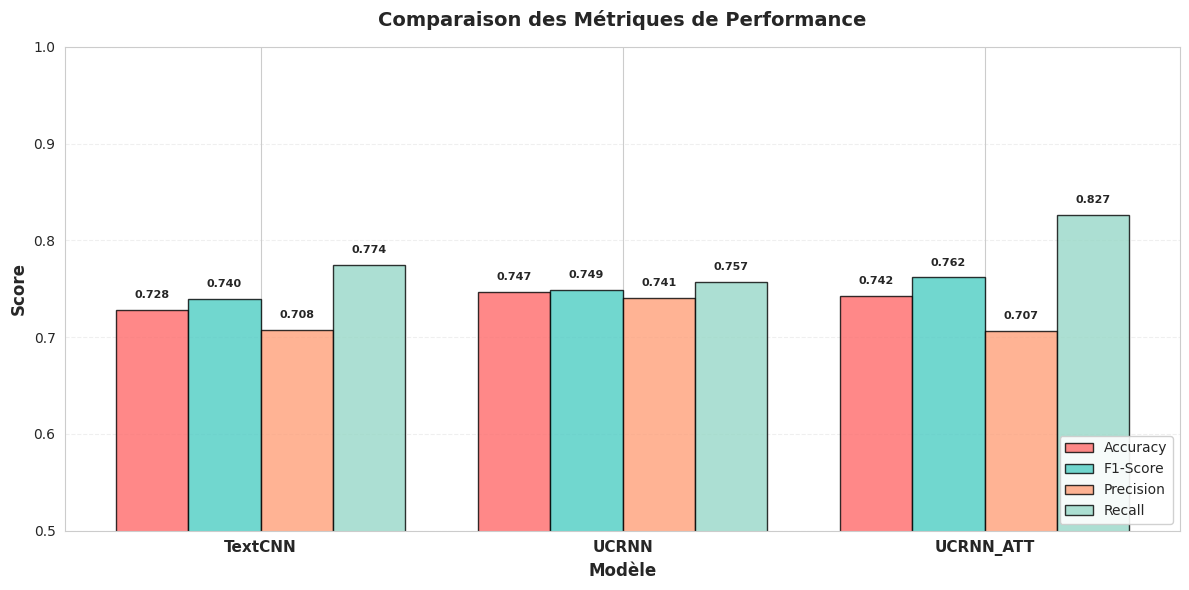

4  Temps d'inférence et d'entrainement


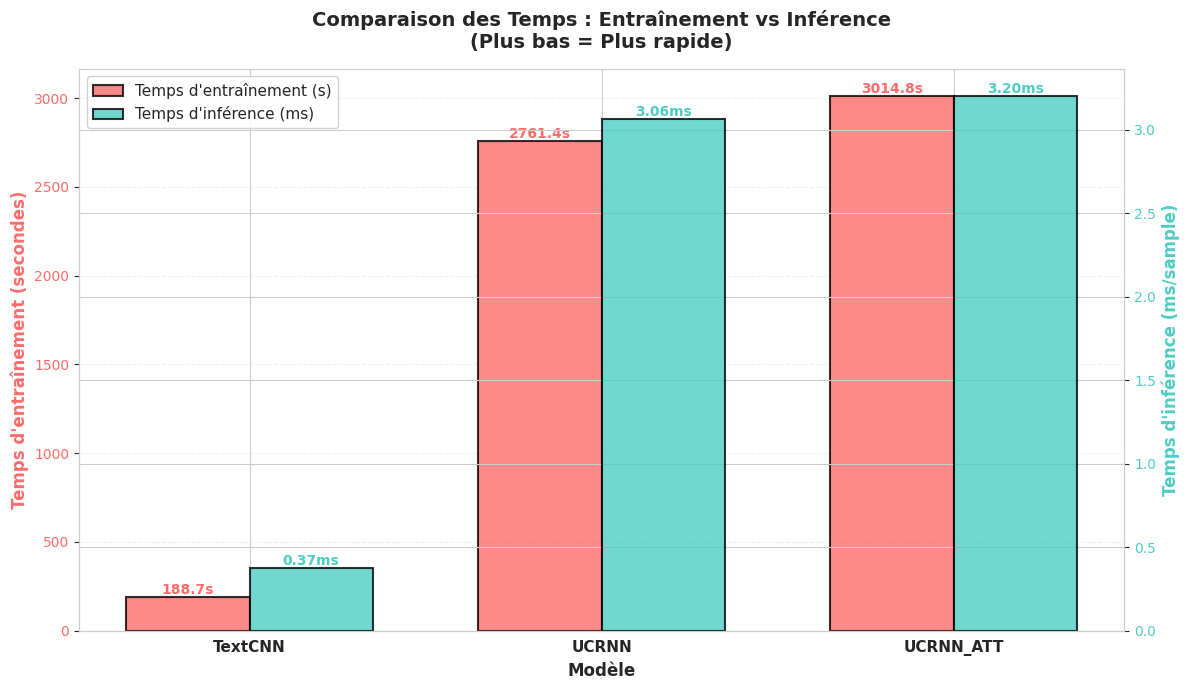

6  Courbes de Loss...


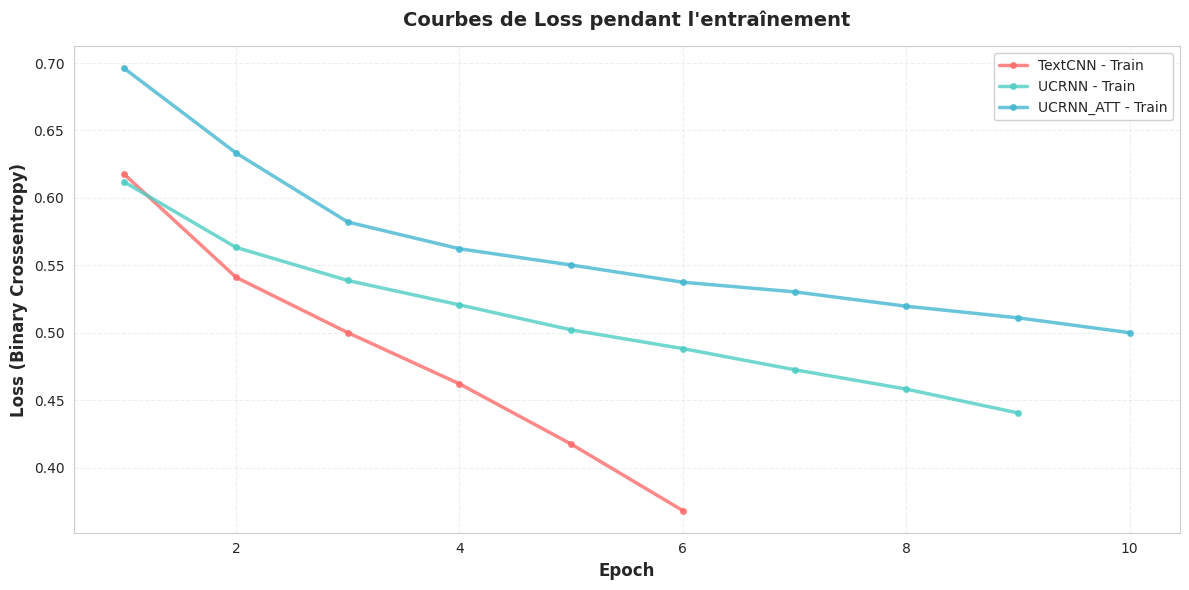

7  Courbes d'Accuracy...


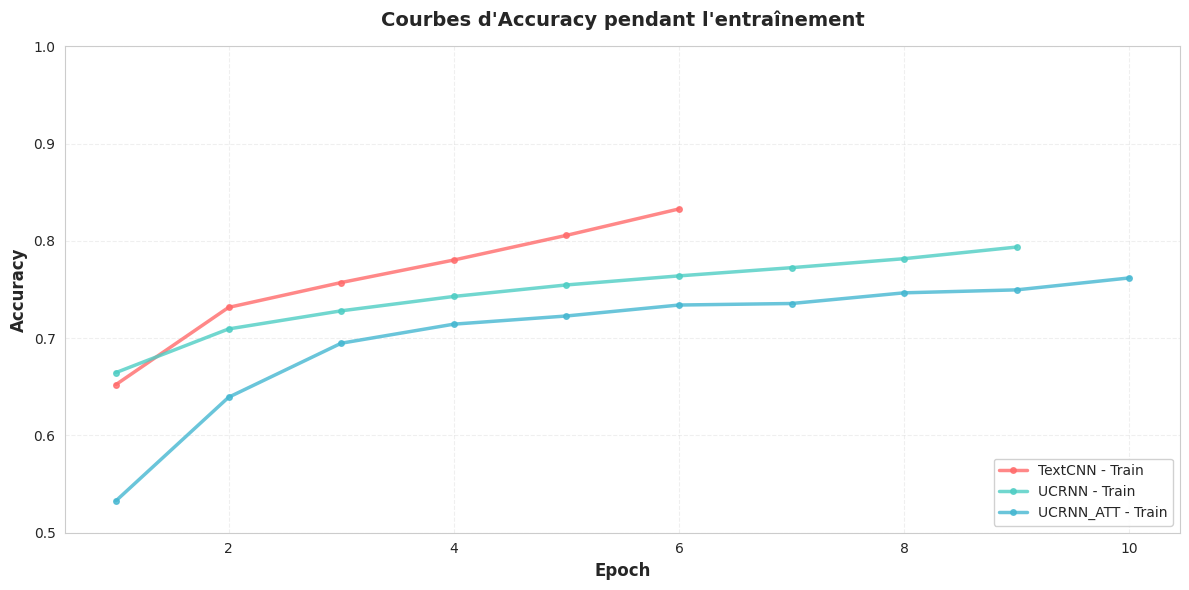


 Tous les graphiques ont été générés



In [30]:
histories = [history_textcnn, history_ucrnn, history_ucrnn_plus]
model_names = ['TextCNN', 'UCRNN', 'UCRNN_ATT']
# df = compare_models_comprehensive(tracker, model_names)
plot_all_comparisons(df_results, histories, model_names)